In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
%matplotlib inline

In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c8220ad3ad3b4c8ab836601aada5d8b6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='KPUDTUt1k-WCXsFJukQpNwTEkwKxq8Zh8Av4AoIopMyP',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_c8220ad3ad3b4c8ab836601aada5d8b6.get_object(Bucket='lifeexpectancy-donotdelete-pr-25qejekawzvg9b',Key='datasets_12603_17232_Life Expectancy Data (1).csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Now that the dataset is loaded into the DataFrame, `df`, it is now time to begin the EDA. The first step of any EDA is data cleaning (AKA data wrangling, data munging, data cleansing).

#  Data Cleaning

### Dataset Description/Variable Descriptions

Before getting into the variable descriptions, the string values for the columns/variables themselves are not very 'clean' so the following is a quick cleaning of the column/variable titles.

In [3]:
orig_cols = list(df.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
df.columns = new_cols

In [5]:
df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

Now that the descriptions of the dataset and variables have been made, a look at the missing values of each variable should be done.

In [6]:
df.describe().iloc[:, 1:]

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


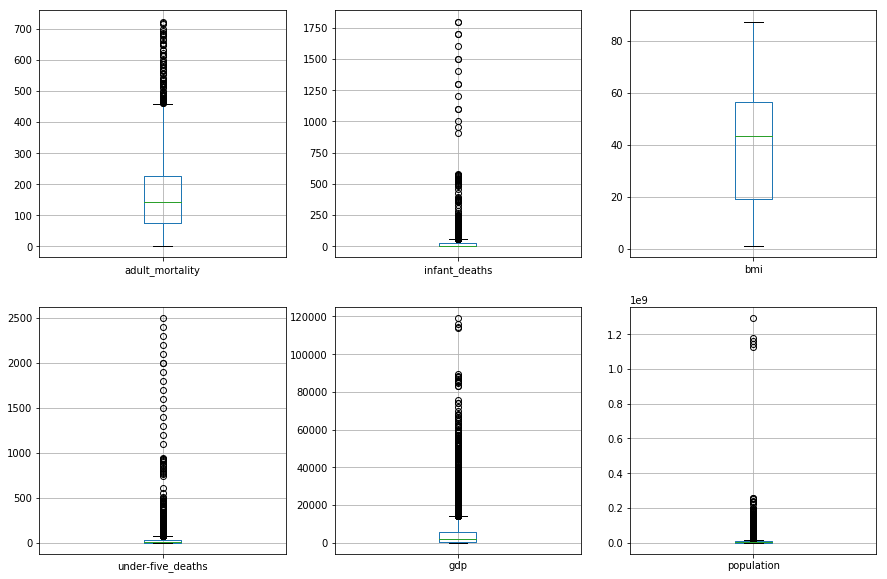

In [7]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['adult_mortality', 'infant_deaths', 'bmi', 'under-five_deaths', 'gdp', 'population'], start=1):
    plt.subplot(2, 3, i)
    df.boxplot(col)

In [8]:
mort_5_percentile = np.percentile(df.adult_mortality.dropna(), 5)
df.adult_mortality = df.apply(lambda x: np.nan if x.adult_mortality < mort_5_percentile else x.adult_mortality, axis=1)
df.infant_deaths = df.infant_deaths.replace(0, np.nan)
df.bmi = df.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi > 50) else x.bmi, axis=1)
df['under-five_deaths'] = df['under-five_deaths'].replace(0, np.nan)

##### All missing values (all explicit now)
Easy way to do this is with `df.info()`:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2783 non-null float64
infant_deaths                      2090 non-null float64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                1482 non-null float64
under-five_deaths                  2153 non-null float64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-

In [10]:
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))

In [11]:
nulls_breakdown()

[iloc = 3] life_expectancy has 10 null values: 0.34% null
[iloc = 4] adult_mortality has 155 null values: 5.28% null
[iloc = 5] infant_deaths has 848 null values: 28.86% null
[iloc = 6] alcohol has 194 null values: 6.6% null
[iloc = 8] hepatitis_b has 553 null values: 18.82% null
[iloc = 10] bmi has 1456 null values: 49.56% null
[iloc = 11] under-five_deaths has 785 null values: 26.72% null
[iloc = 12] polio has 19 null values: 0.65% null
[iloc = 13] total_expenditure has 226 null values: 7.69% null
[iloc = 14] diphtheria has 19 null values: 0.65% null
[iloc = 16] gdp has 448 null values: 15.25% null
[iloc = 17] population has 652 null values: 22.19% null
[iloc = 18] thinness_10-19_years has 34 null values: 1.16% null
[iloc = 19] thinness_5-9_years has 34 null values: 1.16% null
[iloc = 20] income_composition_of_resources has 167 null values: 5.68% null
[iloc = 21] schooling has 163 null values: 5.55% null
Out of 22 total columns, 16 contain null values; 72.73% columns contain null val

Dealing with Missing Values

Nearly half of the BMI variable's values are null, it is likely best to remove this variable altogether.

In [12]:
df.drop(columns='bmi', inplace=True)

Alright, so it looks like there are a lot of columns containing null values, since this is time series data assorted by country, the best course of action would be to interpolate the data by country. However, when attempting to interpolate by country it doesn't fill in any values as the countries' data for all the null values are null for each year, therefore imputation by year may be the best possible method here. Imputation of each year's mean is done below.

In [13]:
imputed_data = []
for year in list(df.year.unique()):
    year_data = df[df.year == year].copy()
    for col in list(year_data.columns)[3:]:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    imputed_data.append(year_data)
df = pd.concat(imputed_data).copy()

In [14]:
nulls_breakdown(df)

Out of 21 total columns, 0 contain null values; 0.0% columns contain null values.


Outliers

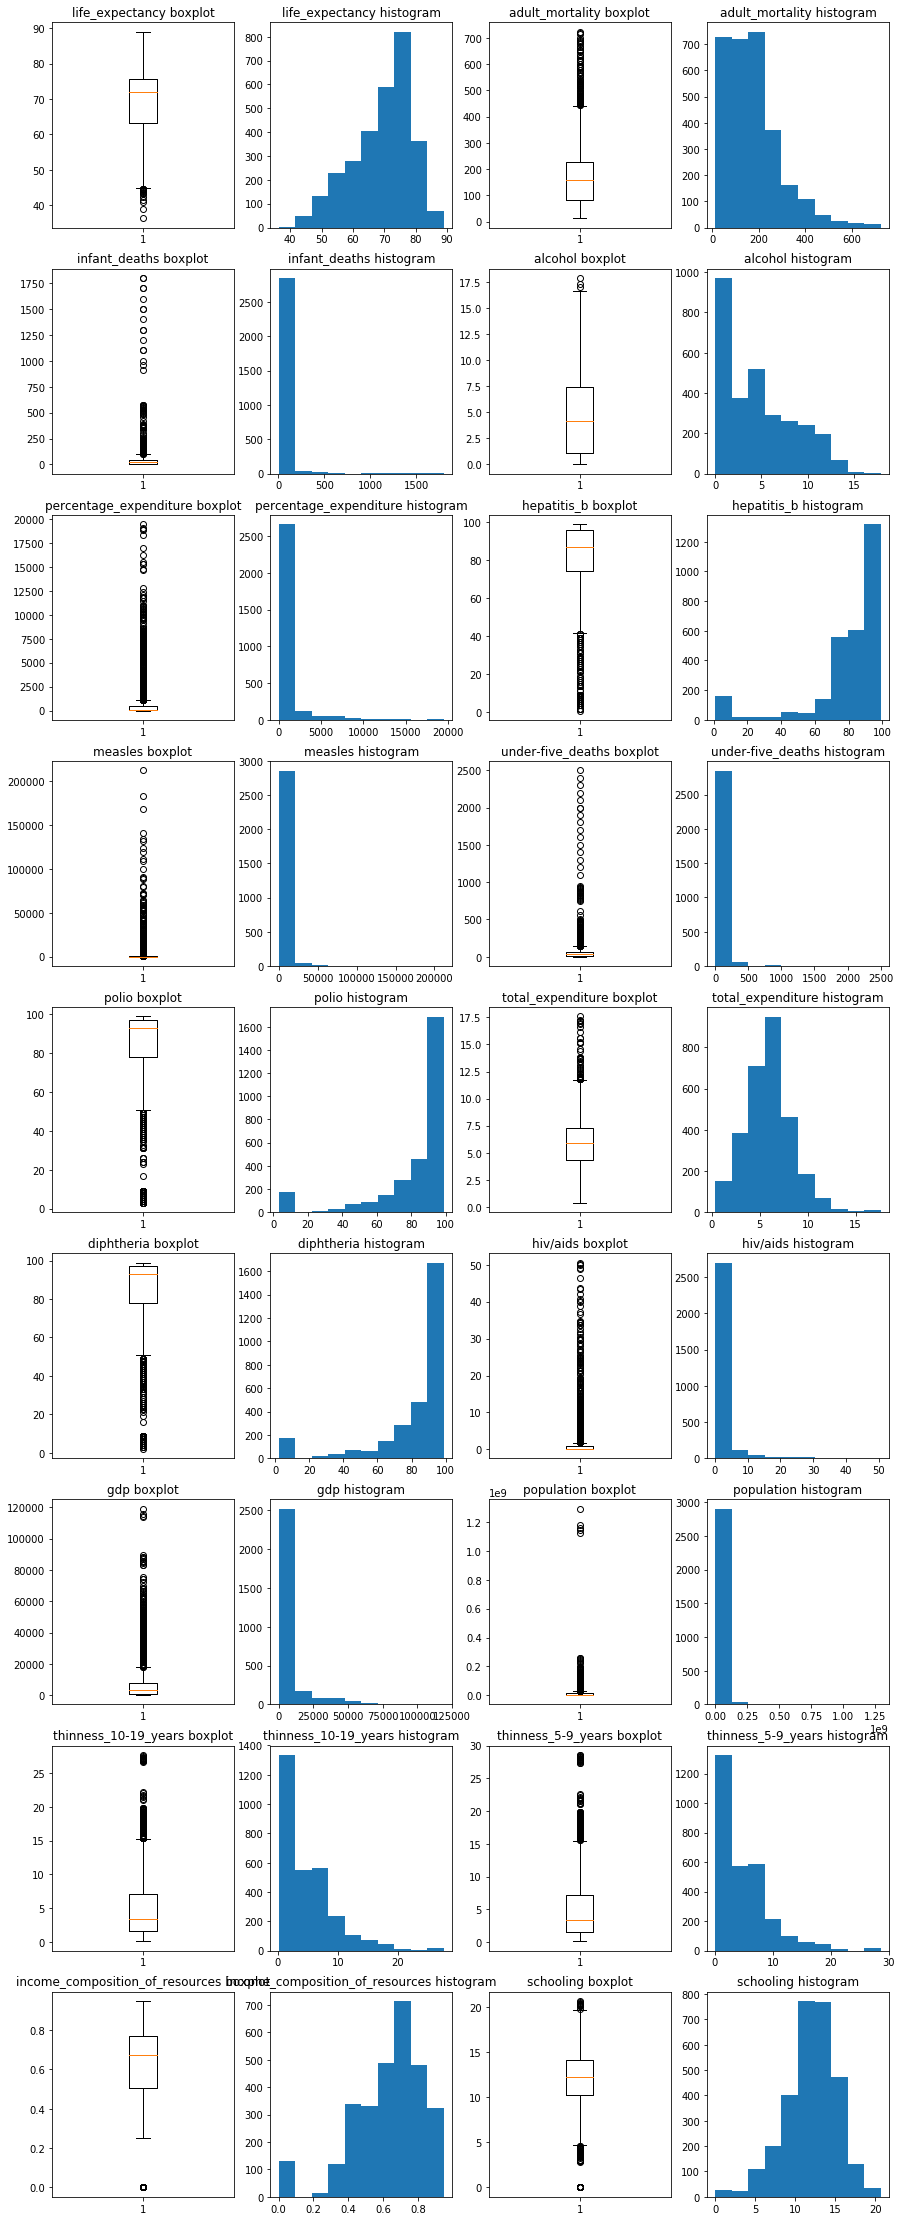

In [15]:
cont_vars = list(df.columns)[3:]
def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()
outliers_visual(df)

Visually, it is plain to see that there are a number of outliers for all of these variables - including the target variable, life expectancy. The same will be done statistically using Tukey's method below - outliers being considered anything outside of 1.5 times the IQR.

In [16]:
def outlier_count(col, data=df):
    print(15*'-' + col + 15*'-')
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    print('Number of outliers: {}'.format(outlier_count))
    print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [17]:
for col in cont_vars:
    outlier_count(col)

---------------life_expectancy---------------
Number of outliers: 17
Percent of data that is outlier: 0.58%
---------------adult_mortality---------------
Number of outliers: 97
Percent of data that is outlier: 3.3%
---------------infant_deaths---------------
Number of outliers: 135
Percent of data that is outlier: 4.59%
---------------alcohol---------------
Number of outliers: 3
Percent of data that is outlier: 0.1%
---------------percentage_expenditure---------------
Number of outliers: 389
Percent of data that is outlier: 13.24%
---------------hepatitis_b---------------
Number of outliers: 222
Percent of data that is outlier: 7.56%
---------------measles---------------
Number of outliers: 542
Percent of data that is outlier: 18.45%
---------------under-five_deaths---------------
Number of outliers: 142
Percent of data that is outlier: 4.83%
---------------polio---------------
Number of outliers: 279
Percent of data that is outlier: 9.5%
---------------total_expenditure---------------

####  Dealing with Outliers

In [18]:
def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(df[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.boxplot(df[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        plt.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()

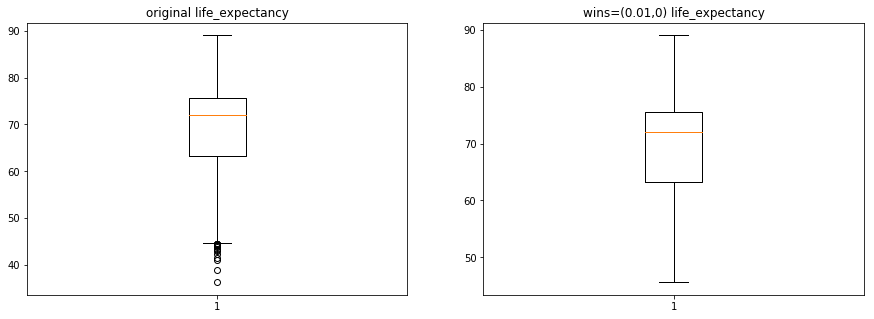

In [19]:
wins_dict = {}
test_wins(cont_vars[0], lower_limit=.01, show_plot=True)
test_wins(cont_vars[1], upper_limit=.04, show_plot=False)
test_wins(cont_vars[2], upper_limit=.05, show_plot=False)
test_wins(cont_vars[3], upper_limit=.0025, show_plot=False)
test_wins(cont_vars[4], upper_limit=.135, show_plot=False)
test_wins(cont_vars[5], lower_limit=.1, show_plot=False)
test_wins(cont_vars[6], upper_limit=.19, show_plot=False)
test_wins(cont_vars[7], upper_limit=.05, show_plot=False)
test_wins(cont_vars[8], lower_limit=.1, show_plot=False)
test_wins(cont_vars[9], upper_limit=.02, show_plot=False)
test_wins(cont_vars[10], lower_limit=.105, show_plot=False)
test_wins(cont_vars[11], upper_limit=.185, show_plot=False)
test_wins(cont_vars[12], upper_limit=.105, show_plot=False)
test_wins(cont_vars[13], upper_limit=.07, show_plot=False)
test_wins(cont_vars[14], upper_limit=.035, show_plot=False)
test_wins(cont_vars[15], upper_limit=.035, show_plot=False)
test_wins(cont_vars[16], lower_limit=.05, show_plot=False)
test_wins(cont_vars[17], lower_limit=.025, upper_limit=.005, show_plot=False)

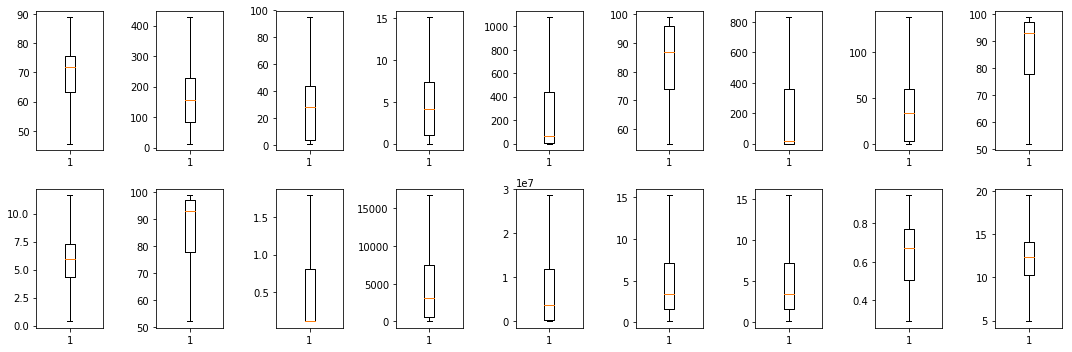

In [20]:
plt.figure(figsize=(15,5))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 9, i)
    plt.boxplot(wins_dict[col])
plt.tight_layout()
plt.show()

Now that the outliers have been dealt with, the data cleaning section is complete.

#  Data Exploration

Before diving into exploration, a new dataframe with the winsorized data should be created.

In [21]:
wins_df = df.iloc[:, 0:3]
for col in cont_vars:
    wins_df[col] = wins_dict[col]

**Descriptive Statistics**

In [22]:
wins_df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.248795,169.191269,28.607323,4.640667,281.501093,83.671293,220.691287,38.640545,85.514684,5.972192,85.469564,0.526991,5033.943592,7.508368e+06,4.703351,4.720470,0.640659,12.049874
std,4.613841,9.462136,107.646049,25.699534,3.910036,384.161450,13.848933,329.192321,37.732345,15.270927,2.302224,15.217611,0.675962,5408.511820,8.646842e+06,3.925702,3.964268,0.171622,3.085673
min,2000.000000,45.600000,13.000000,1.000000,0.010000,0.000000,55.000000,0.000000,1.000000,52.000000,0.370000,52.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,4.900000
25%,2004.000000,63.200000,84.000000,4.000000,1.092500,4.685343,74.099237,0.000000,4.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.000000,157.000000,28.000000,4.140000,64.912906,87.000000,17.000000,34.000000,93.000000,5.910000,93.000000,0.100000,3116.561755,3.675929e+06,3.400000,3.400000,0.673000,12.300000
75%,2012.000000,75.600000,227.000000,43.766917,7.390000,441.534144,96.000000,360.250000,60.014815,97.000000,7.330000,97.000000,0.800000,7464.487887,1.181332e+07,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,428.000000,95.000000,15.140000,1077.712092,99.000000,831.000000,138.000000,99.000000,11.660000,99.000000,1.800000,16784.346160,2.865628e+07,15.300000,15.500000,0.948000,19.500000


In [23]:
wins_df.describe(include='O')

,country,status
count,2938,2938
unique,193,2
top,Lebanon,Developing
freq,16,2426


**Visual Distributions**

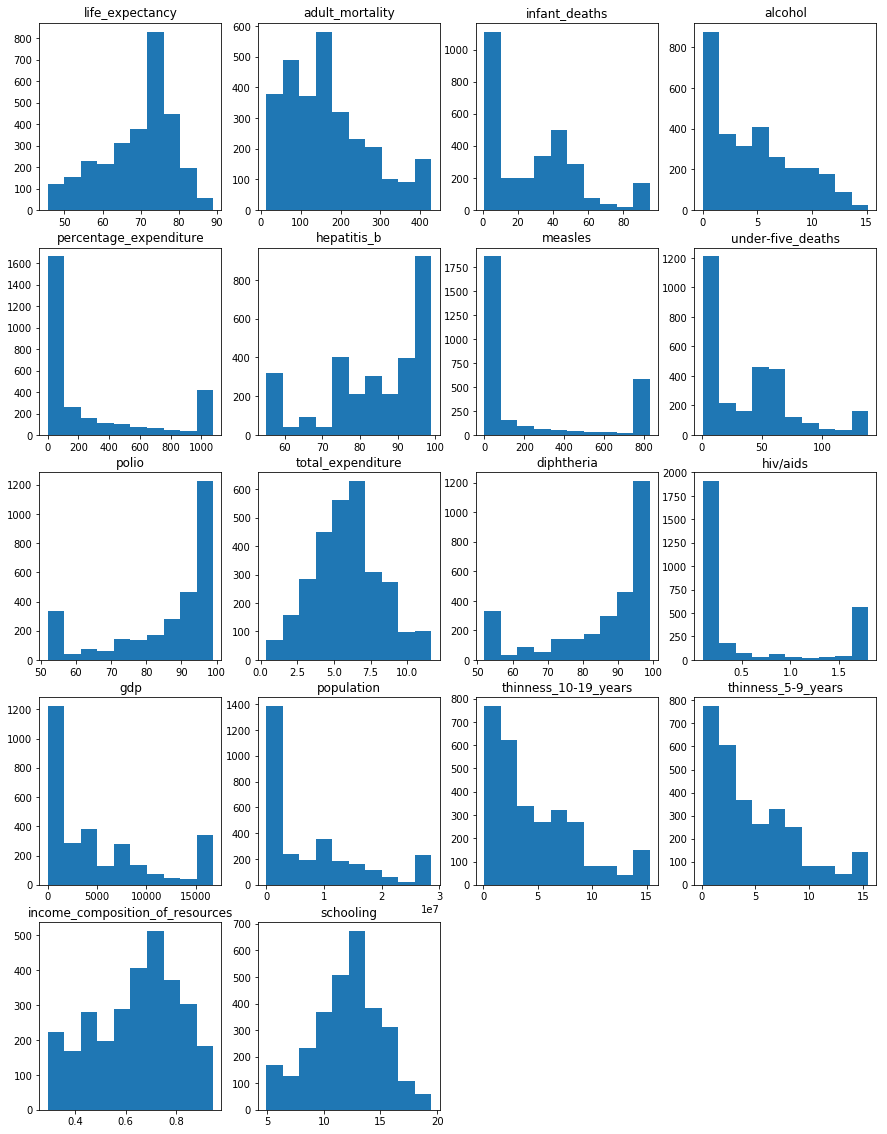

In [24]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(5, 4, i)
    plt.hist(wins_df[col])
    plt.title(col)

The winsorization had a large effect on some variables while not having too much of an effect on others. Even though all of these variables were winsorized in some fashion, some variables are much more obviously winsorized than others. What about the categorical variables, how many of each of these are there in the data (in essence, what is their distribution?)

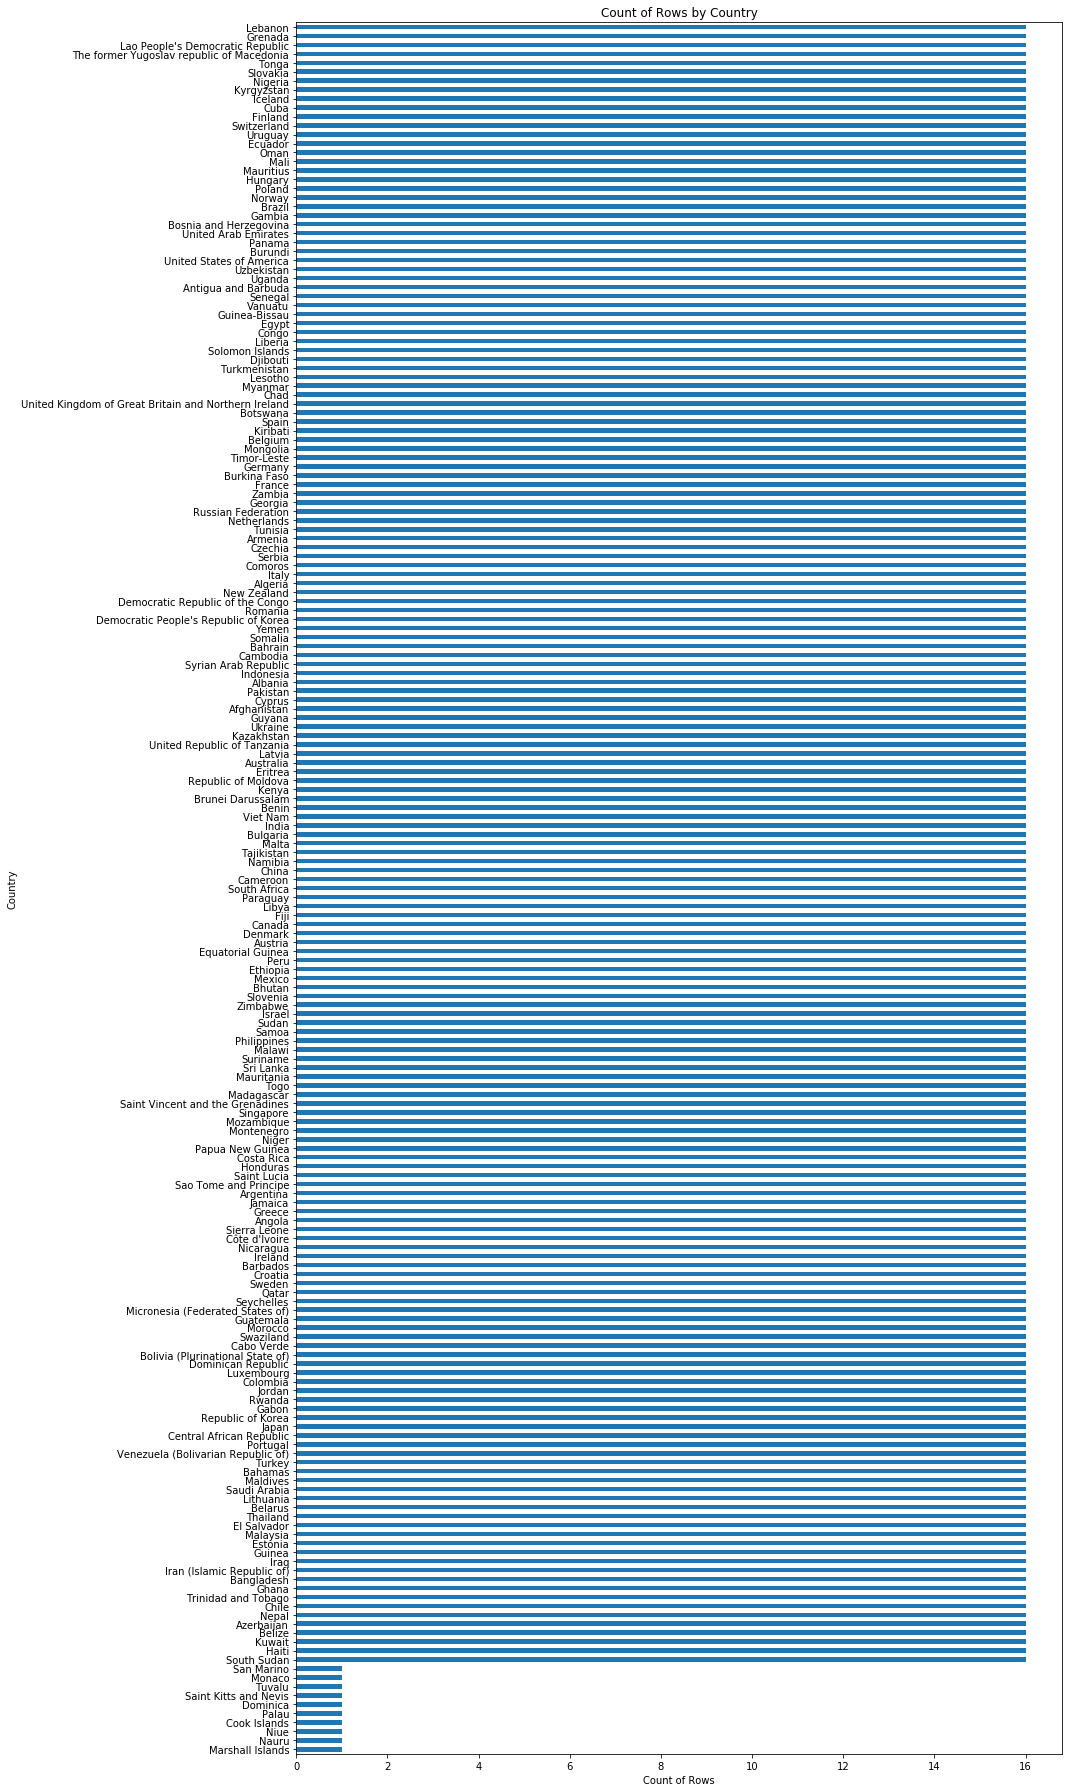

In [25]:
plt.figure(figsize=(15, 25))
wins_df.country.value_counts(ascending=True).plot(kind='barh')
plt.title('Count of Rows by Country')
plt.xlabel('Count of Rows')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

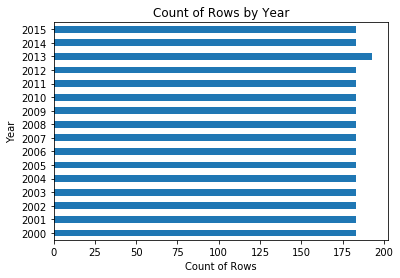

In [26]:
wins_df.year.value_counts().sort_index().plot(kind='barh')
plt.title('Count of Rows by Year')
plt.xlabel('Count of Rows')
plt.ylabel('Year')
plt.show()

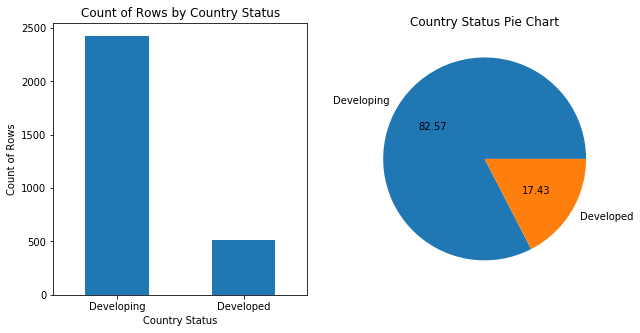

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
wins_df.status.value_counts().plot(kind='bar')
plt.title('Count of Rows by Country Status')
plt.xlabel('Country Status')
plt.ylabel('Count of Rows')
plt.xticks(rotation=0)

plt.subplot(122)
wins_df.status.value_counts().plot(kind='pie', autopct='%.2f')
plt.ylabel('')
plt.title('Country Status Pie Chart')

plt.show()

This graph, though simple, is important. The above displays that the majority of our data comes from countries listed as 'Developing' - 82.57% to be exact. It is likely that any model used will more accurately depict results for 'Developing' countries over 'Developed' countries as the majority of the data lies within countries that are 'Developing' rather than 'Developed'.

###  Bivariate Analysis

#### Continuous to Continuous Analysis

In [28]:
wins_df[cont_vars].corr()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
life_expectancy,1.000000,-0.677680,-0.222292,0.395089,0.488440,0.315120,-0.337887,-0.298626,0.573291,0.222306,0.578952,-0.796939,0.501011,0.011363,-0.514966,-0.512694,0.792878,0.742306
adult_mortality,-0.677680,1.000000,0.119906,-0.187971,-0.293870,-0.214673,0.216200,0.168908,-0.348198,-0.121052,-0.351136,0.596271,-0.297774,-0.000562,0.332904,0.339266,-0.511340,-0.450785
infant_deaths,-0.222292,0.119906,1.000000,-0.062119,-0.094053,-0.196145,0.323610,0.966996,-0.217511,-0.086289,-0.225997,0.124310,-0.059337,0.176352,0.196669,0.202573,-0.178389,-0.191062
alcohol,0.395089,-0.187971,-0.062119,1.000000,0.378069,0.106352,-0.197193,-0.104954,0.265830,0.308434,0.272948,-0.193443,0.389598,-0.036283,-0.436755,-0.427166,0.475112,0.519757
percentage_expenditure,0.488440,-0.293870,-0.094053,0.378069,1.000000,0.122870,-0.194687,-0.131361,0.268385,0.159830,0.268411,-0.295791,0.712940,-0.070366,-0.331693,-0.333748,0.556006,0.530422
hepatitis_b,0.315120,-0.214673,-0.196145,0.106352,0.122870,1.000000,-0.266487,-0.239049,0.608008,0.071100,0.647198,-0.278977,0.172066,-0.004936,-0.134103,-0.139528,0.299493,0.290399
measles,-0.337887,0.216200,0.323610,-0.197193,-0.194687,-0.266487,1.000000,0.368517,-0.320104,-0.161737,-0.315164,0.226305,-0.183792,0.222488,0.359571,0.364201,-0.274976,-0.329274
under-five_deaths,-0.298626,0.168908,0.966996,-0.104954,-0.131361,-0.239049,0.368517,1.000000,-0.281667,-0.096826,-0.291057,0.198160,-0.102372,0.180288,0.235471,0.236927,-0.253539,-0.264996
polio,0.573291,-0.348198,-0.217511,0.265830,0.268385,0.608008,-0.320104,-0.281667,1.000000,0.164149,0.855849,-0.475611,0.309033,0.003618,-0.288660,-0.287206,0.515361,0.509788
total_expenditure,0.222306,-0.121052,-0.086289,0.308434,0.159830,0.071100,-0.161737,-0.096826,0.164149,1.000000,0.176715,-0.110629,0.146954,-0.105257,-0.285700,-0.294560,0.185535,0.259746


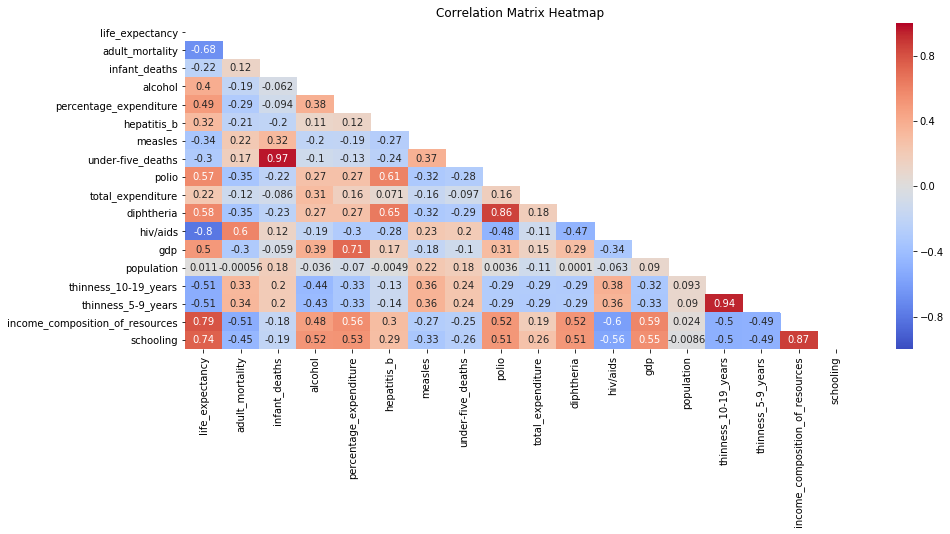

In [29]:
mask = np.triu(wins_df[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(wins_df[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

Note: the values above show rounding at the final two digits, for more exact values, reference the correlation matrix.

### Categorical to Life Expectancy Comparison

First, looking at how life expectancy has changed over the years may be helpful.

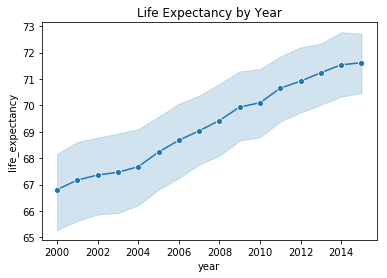

In [30]:
sns.lineplot('year', 'life_expectancy', data=wins_df, marker='o')
plt.title('Life Expectancy by Year')
plt.show()

There appears to definitely be a positive trend over time, but is 15 years of data enough to make the year relevant to a model?

In [31]:
wins_df.year.corr(wins_df.life_expectancy)

0.16979644964459023

In [32]:
years = list(wins_df.year.unique())
years.sort()

In [33]:
yearly_le = {}
for year in years:
    year_data = wins_df[wins_df.year == year].life_expectancy
    yearly_le[year] = year_data

In [34]:
for year in years[:-1]:
    print(10*'-' + str(year) + ' to ' + str(year+1) + 10*'-')
    print(stats.ttest_ind(yearly_le[year], yearly_le[year+1], equal_var=False))

----------2000 to 2001----------
Ttest_indResult(statistic=-0.339874273786677, pvalue=0.734147249286317)
----------2001 to 2002----------
Ttest_indResult(statistic=-0.18288775743069652, pvalue=0.8549879128960569)
----------2002 to 2003----------
Ttest_indResult(statistic=-0.09788073999943862, pvalue=0.922080868750695)
----------2003 to 2004----------
Ttest_indResult(statistic=-0.20076791323205204, pvalue=0.8409921852108724)
----------2004 to 2005----------
Ttest_indResult(statistic=-0.5360239830703207, pvalue=0.5922696887371386)
----------2005 to 2006----------
Ttest_indResult(statistic=-0.43512464639644277, pvalue=0.6637298353979988)
----------2006 to 2007----------
Ttest_indResult(statistic=-0.35499521065847695, pvalue=0.7227988446996725)
----------2007 to 2008----------
Ttest_indResult(statistic=-0.39657900568183463, pvalue=0.6919107746155075)
----------2008 to 2009----------
Ttest_indResult(statistic=-0.5367008466564068, pvalue=0.5918023223783457)
----------2009 to 2010----------
T

Based on the above t-tests, year to year the differences between Life Expectancy do not appear to be significant.

What about status? There is definitely a difference in the amount of count of values between these two variables (found in the prior univariate analysis), but how about the difference between them with respect to Life Expectancy?

In [35]:
wins_df.groupby('status').life_expectancy.agg(['mean'])

,mean
status,
Developed,79.197852
Developing,67.149077


It appears that 'Developed' countries have a much higher average Life Expectancy. But similar to the year comparisons above, is this difference significant? Again, a t-test comparison will be used to find out.

In [36]:
developed_le = wins_df[wins_df.status == 'Developed'].life_expectancy
developing_le = wins_df[wins_df.status == 'Developing'].life_expectancy
stats.ttest_ind(developed_le, developing_le, equal_var=False)

Ttest_indResult(statistic=47.96440581661328, pvalue=2e-323)

#### 2.2.3: Status Variable Compared to other Continuous Variables

In [37]:
wins_df_cols = list(wins_df.columns)
interested_vars = [wins_df_cols[2]]
for col in wins_df_cols[4:]:
    interested_vars.append(col)

In [38]:
wins_df[interested_vars].groupby('status').agg('mean')

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
status,,,,,,,,,,,,,,,,,
Developed,96.516154,27.956075,9.578444,633.176176,86.930131,127.019531,34.917279,94.324219,7.399336,94.316406,0.100000,10145.447190,6.406971e+06,1.320703,1.29668,0.831395,15.462831
Developing,184.529133,28.744767,3.598565,207.281125,82.983525,240.460429,39.426329,83.655458,5.670997,83.602464,0.617106,3955.176138,7.740814e+06,5.417248,5.44305,0.600405,11.329580


From the above, it appears that many of these values are likely correlated to whether a country is 'Developed' or 'Developing'. Again, t-tests are the best way to find out if differences are significant here.

In [39]:
developed_df = wins_df[wins_df.status == 'Developed']
developing_df = wins_df[wins_df.status == 'Developing']
for col in interested_vars[1:]:
    print(5*'-' + str(col) + ' Developed/Developing t-test comparison' + 5*'-')
    print('p-value=' +str(stats.ttest_ind(developed_df[col], developing_df[col], equal_var=False)[1]))

-----adult_mortality Developed/Developing t-test comparison-----
p-value=3.295961777163392e-145
-----infant_deaths Developed/Developing t-test comparison-----
p-value=0.43706003820584804
-----alcohol Developed/Developing t-test comparison-----
p-value=7.259688493240182e-204
-----percentage_expenditure Developed/Developing t-test comparison-----
p-value=1.0654031797381314e-67
-----hepatitis_b Developed/Developing t-test comparison-----
p-value=2.723238539034132e-12
-----measles Developed/Developing t-test comparison-----
p-value=2.938258449568768e-18
-----under-five_deaths Developed/Developing t-test comparison-----
p-value=0.0018370073332902765
-----polio Developed/Developing t-test comparison-----
p-value=3.1739264406706406e-118
-----total_expenditure Developed/Developing t-test comparison-----
p-value=1.1202855294470609e-39
-----diphtheria Developed/Developing t-test comparison-----
p-value=3.0189459362754654e-109
-----hiv/aids Developed/Developing t-test comparison-----
p-value=1.73

# Feature Engineering

In [40]:
feat_df = wins_df.join(pd.get_dummies(wins_df.status)).drop(columns='status').copy()

In [41]:
feat_df.iloc[:, 2:].corr().iloc[:, -2:].T

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Developed,Developing
Developed,0.483121,-0.310207,-0.011644,0.580249,0.420621,0.108121,-0.130744,-0.045339,0.265064,0.284829,0.267119,-0.290242,0.434245,-0.058526,-0.395916,-0.396833,0.51065,0.508211,1.0,-1.0
Developing,-0.483121,0.310207,0.011644,-0.580249,-0.420621,-0.108121,0.130744,0.045339,-0.265064,-0.284829,-0.267119,0.290242,-0.434245,0.058526,0.395916,0.396833,-0.51065,-0.508211,-1.0,1.0


From the above it can be observed that whether a country is 'Developed' or not is certainly correlated with a number of variables, but not extremely highly. However, it does have a very low correlation with Infant Deaths, Under Five Deaths and Population.

Next, the categorical columns, 'year' and 'country' will be dropped as they don't have significant differences among life expectancy.

In [43]:
### you don't get any error here. by mistake i run this cell 2 times
feat_df.drop(columns=['country', 'year'], inplace=True)

KeyError: "['country' 'year'] not found in axis"

From the prior analysis, there are a number of variables that are very or extremely highly correlated with one another. In those cases, the variable which is most highly correlated to Life Expectancy (target variable) will be kept while the others will be dismissed.

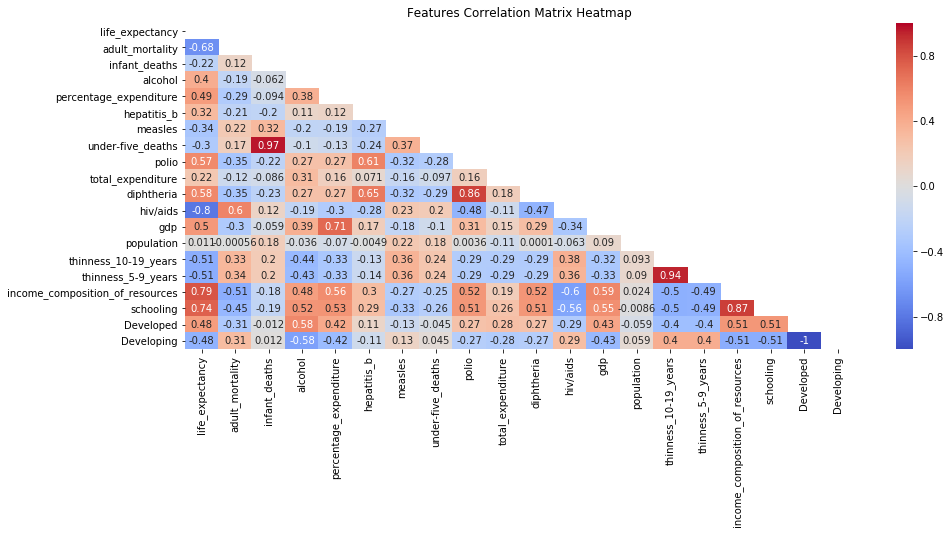

In [44]:
def feat_heatmap():
    mask = np.triu(feat_df.corr())
    plt.figure(figsize=(15,6))
    sns.heatmap(feat_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    plt.ylim(len(feat_df.columns), 0)
    plt.title('Features Correlation Matrix Heatmap')
    plt.show()
feat_heatmap()

In [45]:
feat_df.drop(columns=['infant_deaths', 'percentage_expenditure','polio','thinness_10-19_years','schooling','Developing'], inplace=True)

In addition to the above variables, it may also be useful to drop variables which are not very correlated with any of the other variables, the only variable where that is the case is 'Population'.

In [46]:
feat_df.drop(columns=['population'], inplace=True)

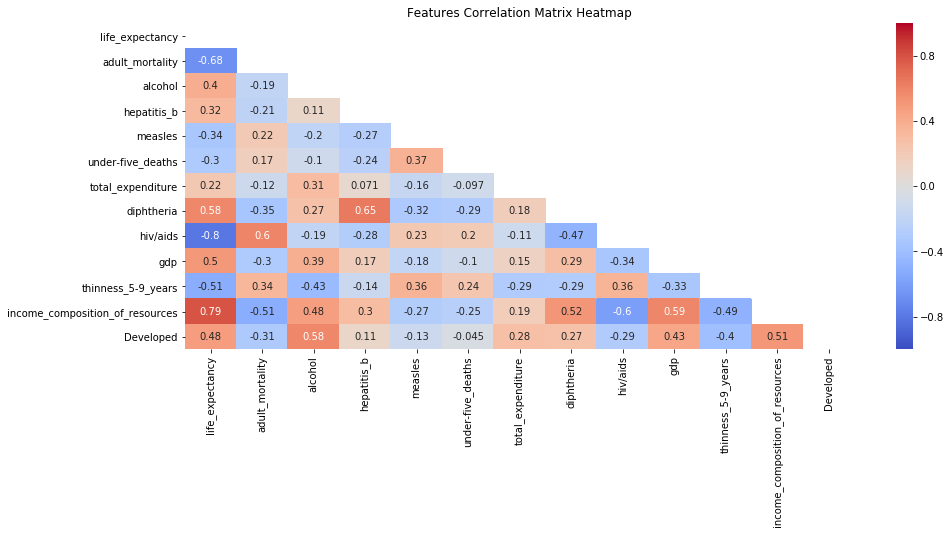

In [46]:
feat_heatmap()

### PCA

In [47]:
pca_df = feat_df.drop(columns='Developed').copy()

PCA is an unsupervised technique so the target variable is not needed and can be dropped.

In [48]:
pca_df.drop(columns='life_expectancy', inplace=True)

In [49]:
len(pca_df.columns)

11

In [50]:
X = scale(pca_df)
sklearn_pca = PCA()
Y = sklearn_pca.fit_transform(X)
print('Explained variance by Principal Components:', sklearn_pca.explained_variance_ratio_)
print('Eigenvalues:', sklearn_pca.explained_variance_)

Explained variance by Principal Components: [0.36685507 0.12232886 0.10672368 0.08538371 0.07439446 0.05833868
 0.05266908 0.04432076 0.03761047 0.02699705 0.02437817]
Eigenvalues: [4.03677981 1.34607566 1.17436016 0.93954064 0.81861773 0.64194395
 0.57955711 0.48769433 0.41385604 0.29706869 0.26825119]


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


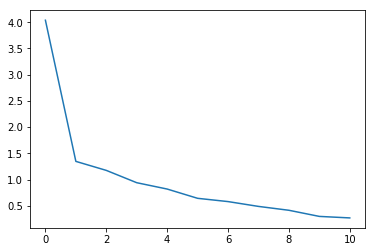

PC1 Explained Variance: 36.69%


In [51]:
plt.plot(sklearn_pca.explained_variance_)
plt.show()
print('PC1 Explained Variance:', str(round(sklearn_pca.explained_variance_ratio_[0]*100, 2))+'%')

#### In this case, perhaps more features > less features

Ultimately, I would probably start modeling using the features prior to the PCA method. Those features are as follows:
1. Adult Mortality
2. Alcohol
3. Hepatitis B
4. Measles
5. Under-Five Deaths
6. Total Expenditure
7. Diphtheria
8. HIV/AIDS
9. GDP
10. Thinness 5-9 Years
11. Income Composition Of Resources
12. Developed

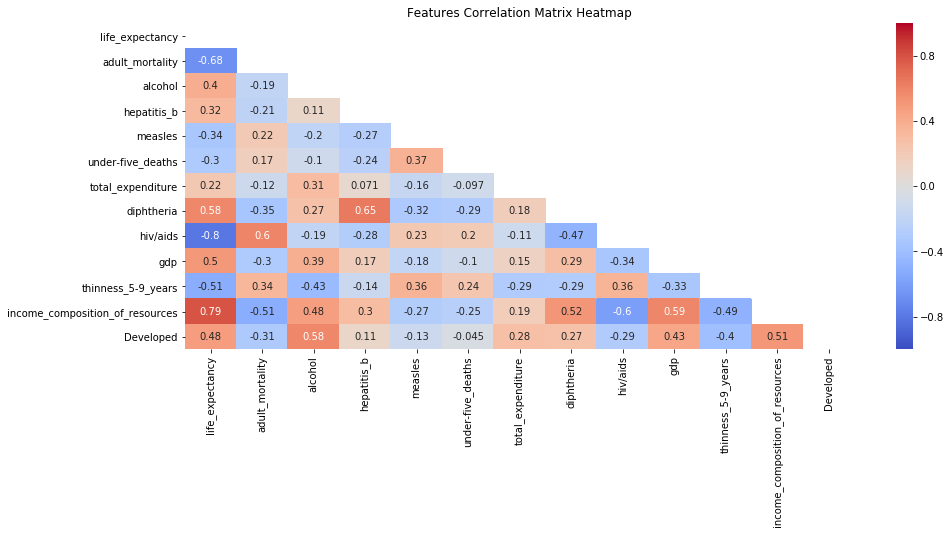

In [52]:
feat_heatmap()

In [54]:
feat_df.head()

,life_expectancy,adult_mortality,alcohol,hepatitis_b,measles,under-five_deaths,total_expenditure,diphtheria,hiv/aids,gdp,thinness_5-9_years,income_composition_of_resources,Developed
0,65.0,263.0,0.010000,65.0,831,83.000000,8.16,65.0,0.1,584.259210,15.5,0.479,0
16,77.8,74.0,4.600000,99.0,0,44.844961,6.00,99.0,0.1,3954.227830,1.3,0.762,0
32,75.6,19.0,5.288333,95.0,63,24.000000,7.08,95.0,0.1,4132.762920,5.8,0.743,0
48,52.4,335.0,5.288333,64.0,118,98.000000,7.08,64.0,1.8,3695.793748,8.2,0.531,0
64,76.4,13.0,5.288333,99.0,0,44.844961,7.08,99.0,0.2,13566.954100,3.3,0.784,0


In [55]:
feat_df.shape

(2938, 13)

In [56]:
df1 = feat_df

In [57]:
a=list(df1.columns)
b=[]
for i in a:
    c=df1[i].isnull().sum()
    b.append(c)
null_df=pd.DataFrame({'Feature name':a,'no. of Nan':b})
null_df

,Feature name,no. of Nan
0,life_expectancy,0
1,adult_mortality,0
2,alcohol,0
3,hepatitis_b,0
4,measles,0
5,under-five_deaths,0
6,total_expenditure,0
7,diphtheria,0
8,hiv/aids,0
9,gdp,0


In [58]:
y=df1['life_expectancy']
X=df1.drop('life_expectancy',axis=1)

In [59]:
X.shape

(2938, 12)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [61]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [62]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
y_pred = np.array(y_pred)
y_test = np.array(y_test)

print(np.concatenate((y_pred.reshape(len(y_test),1), y_test.reshape(len(y_test),1)),1))

[[58.79 59.2 ]
 [71.06 69.5 ]
 [54.65 55.3 ]
 ...
 [71.77 71.5 ]
 [68.31 67.9 ]
 [57.07 61.5 ]]


In [63]:
accuracy_score =  regressor.score(X_test,y_test)
print(accuracy_score)

0.9461070149814441


In [1]:
### Here i am gonna use RandomForestRegressor because it is giving more accuracy than other algo

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(mean_squared_error(y_test,y_pred)**(0.5))

2.131093748729309


In [65]:
from sklearn.linear_model import LinearRegression

In [66]:
Linear_model= LinearRegression()
Linear_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [67]:
accuracy_score2 =  Linear_model.score(X_test,y_test)
print(accuracy_score2)

0.8381060624190693


In [68]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

2020-07-02 18:05:27,046 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.


In [69]:
wml_credentials = {
  "apikey": "cNmnifP-PGCmzcjhw9p5fQucduKuo3r94vTt_2uIXClD",
  "iam_apikey_description": "Auto-generated for key 5c6c46dd-a54d-4dfa-934f-d0b986e5fdcc",
  "iam_apikey_name": "Service credentials-3",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/71172d6d8b634783a71aa251ca15a717::serviceid:ServiceId-3dc8f19a-1efc-452b-bc71-338caaa1b71b",
  "instance_id": "198a8437-ec6b-41cc-a405-404958295cec",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

In [70]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [71]:
model_props = {
    client.repository.ModelMetaNames.AUTHOR_NAME : "jyothi",
    client.repository.ModelMetaNames.AUTHOR_EMAIL : "jyothiniranjanburla@gmail.com",
    client.repository.ModelMetaNames.NAME : "Life Expectancy"
}

In [73]:
model_artifact = client.repository.store_model(regressor,meta_props = model_props)

In [74]:
model_artifact

{'metadata': {'guid': '5ea204bc-6580-465a-b120-e523dfff2d75',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/published_models/5ea204bc-6580-465a-b120-e523dfff2d75',
  'created_at': '2020-07-02T18:05:27.326Z',
  'modified_at': '2020-07-02T18:05:27.371Z'},
 'entity': {'runtime_environment': 'python-3.6',
  'learning_configuration_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/published_models/5ea204bc-6580-465a-b120-e523dfff2d75/learning_configuration',
  'author': {'name': 'jyothi'},
  'name': 'Life Expectancy',
  'learning_iterations_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/published_models/5ea204bc-6580-465a-b120-e523dfff2d75/learning_iterations',
  'feedback_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/published_models/5ea204bc-6580-465a-b120-e523dfff2d75/feedback',
  'latest_version': {'url': 'h

In [75]:
guid = client.repository.get_model_uid(model_artifact)

In [76]:
guid

'5ea204bc-6580-465a-b120-e523dfff2d75'

In [77]:
deploy = client.deployments.create(guid,name="Life Expectancy Prediction")



#######################################################################################

Synchronous deployment creation for uid: '5ea204bc-6580-465a-b120-e523dfff2d75' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='b399d944-c075-4a3d-9a73-3a10bcff6b6e'
------------------------------------------------------------------------------------------------




In [78]:
deploy

{'metadata': {'guid': 'b399d944-c075-4a3d-9a73-3a10bcff6b6e',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/deployments/b399d944-c075-4a3d-9a73-3a10bcff6b6e',
  'created_at': '2020-07-02T18:07:37.132Z',
  'modified_at': '2020-07-02T18:07:37.417Z'},
 'entity': {'runtime_environment': 'python-3.6',
  'name': 'Life Expectancy Prediction',
  'scoring_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/deployments/b399d944-c075-4a3d-9a73-3a10bcff6b6e/online',
  'deployable_asset': {'name': 'Life Expectancy',
   'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/published_models/5ea204bc-6580-465a-b120-e523dfff2d75',
   'guid': '5ea204bc-6580-465a-b120-e523dfff2d75',
   'created_at': '2020-07-02T18:07:37.106Z',
   'type': 'model'},
  'description': 'Description of deployment',
  'status_details': {'status': 'DEPLOY_SUCCESS'},
  'model_type': 'scikit-learn-0.20',


In [79]:
scoring_url = client.deployments.get_scoring_url(deploy)

In [80]:
scoring_url

'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/198a8437-ec6b-41cc-a405-404958295cec/deployments/b399d944-c075-4a3d-9a73-3a10bcff6b6e/online'